# <center>Analytic modeling of the recurrent oubreak of the novel Coronavirus Disease 2019 epidemics</center>
## <center>Case of The Republic of Croatia</center>

<center>
    Ante Lojic Kapetanovic <br>
    <a href="alojic00@fesb.hr">alojic00@fesb.hr</a> <br>
    Faculty of electrical engineering, mechanical engineering and naval architecture <br>
    University of Split <br>
    Split, Croatia
</center>

**Description** $-$ This report is an attempt at analytical modeling of repeated outbreaks of the Coronavirus Disease 2019 (COVID-19) epidemic for the use case of The Republic of Croatia. The idea of the mentioned approach lies in observing the epidemic and the sudden jumps and falls of the total number of actively infected individuals as a series of *pulses* which represent the current presence of the virus in the population, conditioned by numerous factors. Results of the report show the direct dependence of the number of actively infected individuals on the effective reproduction number immediately before. Also, an exceptional fit of the dynamics of the number of active cases with the series of Heidler functions is achived through CoroPy, Python package for COVID-19 epidemics modeling.

**Keywords** $-$ Coronavirus disease 2019, recurrent epidemic outbreaks modeling, Heidler function, least-squares optimization

**Software** $-$ Ubuntu 18.04 LTS, Python 3.7.6, CoroPy package

In [1]:
# IMPORT LIBS
import os
import datetime as dt

from coropy.growth_models import GrowthCOVIDModel
import coropy.reproduction_rate as R
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

import plotting

In [2]:
# configure plotting
plotting.configure(grid=False)
hex_blue = plotting.default_colors('blue')
hex_red = plotting.default_colors('red')
hex_purple = plotting.default_colors('purple')

In [3]:
# load data
DATA_DIR = 'data'
FILE_NAMES = ['1st_wave_data_cro.csv',
              '2nd_wave_data_cro.csv']
FILE_PATHS = [os.path.join(os.pardir, DATA_DIR, FILE_NAMES[0]),
              os.path.join(os.pardir, DATA_DIR, FILE_NAMES[1])]
df_1 = pd.read_csv(FILE_PATHS[0])
df_2 = pd.read_csv(FILE_PATHS[1])
df = pd.concat([df_1, df_2[1:-1]], sort=False)

cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)
active = cum_positives - cum_recovered - cum_deceased

# start of different epi waves
eff_dates=[dt.datetime(2020, 2, 25), dt.datetime(2020, 6, 1), dt.datetime(2020, 8, 8)]

In [4]:
def heidler(t, t1, t2, n, a, b):
    exp_1 = 1 - np.exp(-t/t1)
    exp_2 = np.exp(-t/t2)
    # if np.sign is not used NumPy will generate RuntimeWarning: invalid value encountered in power
    # https://stackoverflow.com/questions/45384602/numpy-runtimewarning-invalid-value-encountered-in-power#45384691
    return a/b * np.sign(exp_1) * (np.abs(exp_1))**np.abs(n) * exp_2  

In [5]:
X = []
Y = []

# past wave(s)
start_idx = 0
for start_date, end_date in zip(eff_dates[:-1], eff_dates[1:]):
    end_idx = start_idx+abs((end_date - start_date).days)
    
    model = GrowthCOVIDModel(heidler, normalize=True, calc_ci=False)
    model.fit(active[start_idx:end_idx])
    x, fitted = model.get_fitted
    X.extend(x)
    Y.extend(fitted)
    
    start_idx = end_idx  # update indexing

# current wave   
model = GrowthCOVIDModel(heidler, normalize=True, calc_ci=False)
model.fit(active[start_idx:])
x, fitted = model.get_fitted
X.extend(x)
Y.extend(fitted)

In [6]:
# goodness-of-fit
sre_fit = np.sqrt(np.mean((active - Y)**2))
r2_fit = r2_score(active, Y)
print(
    f'S = {sre_fit}',
    f'\nr2 = {r2_fit}'
)

S = 44.54295733722221 
r2 = 0.9965800333709606


In [7]:
# dates
t = np.arange(cum_positives.size)
start_dt = dt.datetime(2020, 2, 25)
end_dt = start_dt + dt.timedelta(int(t.max())+1)
dates = matplotlib.dates.drange(start_dt, end_dt, dt.timedelta(days=1))

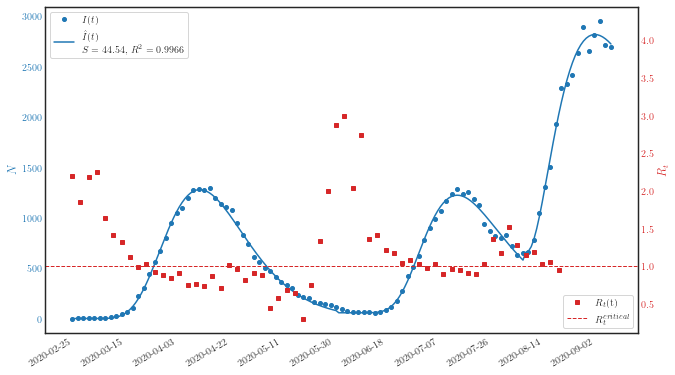

In [10]:
fig, ax1 = plt.subplots()
ax1.plot(dates, active, marker='o', markersize=4, linestyle='none', c=hex_blue, markevery=2, label='$I(t)$')
ax1.plot(dates, Y, c=hex_blue, label=f'$\\hat I(t)$\n$S = {round(sre_fit, 2)}$, $R^2 = {round(r2_fit, 4)}$')
ax1.tick_params(axis='y', labelcolor=hex_blue)
ax1.set_ylabel('$N$', color=hex_blue)
ax1.legend(frameon=True)

ax2 = ax1.twinx()
ax2.plot(dates[:-15-3+1], R._estimate(cum_positives, 15, 3), 's', markevery=3, markersize=4, c=hex_red, label='$R_t$(t)')
ax2.axhline(y=1, linestyle='--', linewidth=1, c=hex_red, label='$R_t^{critical}$')
ax2.tick_params(axis='y', labelcolor=hex_red)
ax2.set_ylabel('$R_t$', color=hex_red)
ax2.legend(loc='lower right', frameon=True)


fig.tight_layout()
_ = fig.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=19))
_ = plt.gcf().autofmt_xdate()
plt.show()

In [9]:
fname = f'Heidler-pulses'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), format='pdf', bbox_inches='tight')